Reference: https://github.com/tensorchiefs/dl_book/blob/master/chapter_07/nb_ch07_02.ipynb

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [100]:
sigma = 3
xmin, xmax = -5, 5
ymin, ymax = -40, 40
nbins_c=30
num = 4

np.random.seed(2)
x = np.linspace(-2, 2, num=num)
y = 2 * x - 1 + np.random.normal(0, sigma, num)

x = x[:, np.newaxis]

## MaxLike estimation of the coefficients

In [101]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression(fit_intercept=True)
regr.fit(x,y)

a_ml = regr.coef_[0]
b_ml = regr.intercept_
print('a_ml:', a_ml, 'b_ml:', b_ml)

a_ml: 2.9205102572725834 b_ml: -1.726712471421449


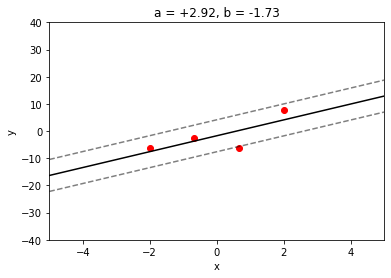

In [102]:
def make_ml_plot(a, b, ax):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('a = {:+.2f}, b = {:+.2f}'.format(a, b))  
    ax.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
    ax.plot([xmin, xmax], [a*xmin+b+1.96*sigma, a*xmax+b+1.96*sigma], ls='dashed', alpha=0.5, color='black')
    ax.plot([xmin, xmax], [a*xmin+b-1.96*sigma, a*xmax+b-1.96*sigma], ls='dashed', alpha=0.5, color='black')
    ax.scatter(x, y, color='r')
    
f, ax = plt.subplots(1,1)
make_ml_plot(a_ml, b_ml, ax)

Compute $p(y | x, a, b)$.

* `x = np.linspace(xmin, xmax, nbins_c)`
* `y = np.linspace(ymin, ymax, nbins_c)`
* Compute $p(y_j | x_i, a, b)$ from $N(a x_i + b, \sigma)$ for each $i$ and $j$.

In [103]:
xx, yy = np.meshgrid(np.linspace(xmin, xmax, nbins_c, dtype='float32'), np.linspace(ymin, ymax, nbins_c, dtype='float32'))

xx_ravel_tensor = tf.constant(xx.ravel()[:,None])
yy_ravel_tensor = tf.constant(yy.ravel()[:,None])

In [104]:
# def pre_distribution(a, b):
#     p = np.zeros((nbins_c, nbins_c), dtype=np.float32)
#     for i in range(nbins_c):
#         for j in range(nbins_c):
#             p[i,j] = tfd.Normal(a*xx[i,j] + b, sigma).prob(yy[i,j])
#     p = p / p.sum(axis=0)
#     return p

In [111]:
@tf.function
def pre_distribution(theta):
    p = tfd.Normal(theta[0]*xx_ravel_tensor + theta[1], sigma).prob(yy_ravel_tensor)
    p = tf.reshape(p, (nbins_c, nbins_c))
    p = p / tf.reduce_sum(p, axis=0)
    return p

In [112]:
import scipy
contour_levels = [scipy.stats.norm(0, sigma).pdf(1.96*sigma)]

def plot_cpd(p, fig, ax, a=a_ml, b=b_ml):
    im = ax.pcolormesh(xx, yy, p, cmap=plt.cm.viridis_r, shading='auto')
    ax.contour(xx, yy, p, contour_levels)
    fig.colorbar(im, ax=ax)
    ax.scatter(x, y, marker='o',c='r')
    ax.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
    ax.set_xlabel('x (from {} to {}) in {} bins'.format(xmin, xmax, nbins_c))
    ax.set_ylabel('y (from {} to {}) in {} bins'.format(ymin, ymax, nbins_c))
    ax.set_title('CPD p(y|x,a={},b={})'.format(round(a,2),round(b,2)))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

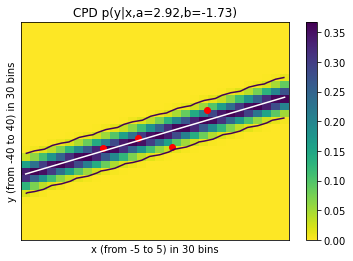

In [113]:
theta = tf.constant([a_ml, b_ml], dtype=tf.float32)
p_ml = pre_distribution(theta).numpy()
fig, ax = plt.subplots(nrows=1)
plot_cpd(p_ml, fig, ax)

## Combining serveral predictive distributions

$p(y|x) = \sum_{\theta_i} p(\theta_i) p(y | x, \theta_i)$, where $\theta_i = (a_i, b_i)$.

* $p(\theta_i) = p(D|\theta_i) / \sum_{\theta_j}p(D|\theta_j)$, the normalized likelihood; $D=\{(x_n, y_n):n=1,\ldots,N\}$

* $p(D|\theta_i) = \prod_n N(y_n | x_n, \theta_i)$

* $p(y | x, \theta_i) = N(y=a_i x + b_i, \sigma)$

In [48]:
y_tensor = tf.constant(y[:,None].astype('float32'))

In [114]:
# p(D|theta)
@tf.function
def unnormalized_likehihood(theta): 
    y_prob = tfd.Independent(tfd.Normal(loc=theta[0]*x + theta[1], scale=sigma)).prob(y_tensor)
    return tf.reduce_prod(y_prob)

nbins = 30
amin, amax = -3, 8
bmin, bmax = -10, 8
aa, bb = np.meshgrid(np.linspace(amin, amax, nbins), np.linspace(bmin, bmax, nbins))
theta = np.vstack([aa.flatten(), bb.flatten()]) # theta.shape: (2, nbins*nbins)
norm_like = np.zeros((nbins*nbins))

theta_i = tf.Variable([0., 0.,])
for i in range(len(norm_like)):
    theta_i.assign(theta[:,i])
    norm_like[i] = unnormalized_likehihood(theta_i)
    
norm_like = norm_like / norm_like.sum()
norm_like = norm_like.reshape((nbins, nbins))
# norm_like is p(a,b)

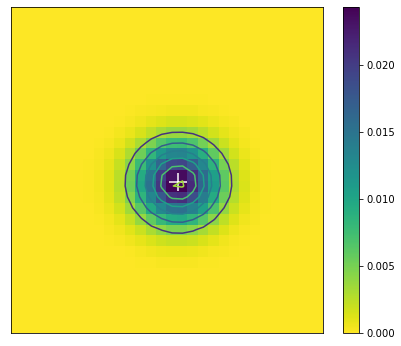

In [115]:
# Graph of p(a,b)
fig, ax = plt.subplots(nrows=1, figsize=(7,6))
im = plt.pcolormesh(aa, bb, norm_like, shading='auto', cmap=plt.cm.viridis_r)
fig.colorbar(im, ax=ax)
plt.contour(aa, bb, norm_like)
plt.scatter(a_ml, b_ml, color='w', marker='+', s=300)
plt.xticks([])
plt.yticks([])
plt.show()

$p(y|x) = \sum_{\theta_i} p(\theta_i) p(y | x, \theta_i)$

In [116]:
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32)

theta = tf.Variable([0., 0.])
for i in range(nbins):
    for j in range(nbins):
        theta.assign([aa[i,j],bb[i,j]])
        pyx += norm_like[i,j] * pre_distribution(theta) 

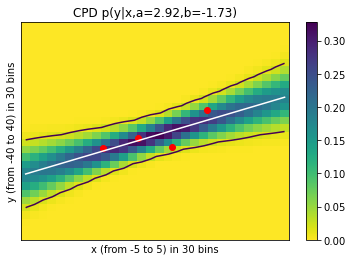

In [117]:
fig, ax = plt.subplots(nrows=1)
plot_cpd(pyx, fig, ax)